## Домашняя работа 8
фев'24
<hr>

### Часть 1. EDA

<br>Скачаны данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
<br>Основные шаги работы с данными:
<ul><li>исклбючены ненужные признаки: id, name, host_id, host_name, last_review</li>
<li>визуализированы базовые статистики данных: распределения признаков, матрица попарных корреляций, построены pair plots</li>
<li>про результатам анализа произведена предобработка переменных</li></ul>

Обозначения
<br><b><span style="color:red">depricated:</span></b> <span style="color:lightgray"> drop_candidate='number_of_reviews'</span> - ислледование проведено, направление анализа отклонено
<br><b>Strong correlation (>0.8): 0 pairs</b> - локальные выводы
<br><b><span style="color:red">Hypothesis: </span></b>  reviews_per_month = number_of_reviews / month_count - рабочие гипотезы,  появившиеся в ходе анализа данных

Критичные по скорости шаги сопровождены %%time

In [1]:
# !pip install numpy pandas seaborn matplotlib plotly scikit-learn kaggle category_encoders
# !pip install pyarrow # !!!!!!!!!!!!!!!!!

In [2]:
%%time

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML, display

from scipy.stats import zscore


CPU times: user 1.8 s, sys: 411 ms, total: 2.21 s
Wall time: 1.64 s


In [3]:
def color_text(val):
    if val == 0:
        color = 'red'
    else:
        color = 'black'
    return 'color: %s' % color

def short_describe(df, sample_size=5, repiter=125):
    '''
    Простая сборка описаний датасета.
    '''
    repiter='>'*repiter
    nRow, nCol = df.shape
    null_rows=df.isna().any(axis=1).sum()
    display(HTML(f'''
    <b>Shape:</b> {nRow} rows x {nCol} columns
    <br><b>Duplicates:</b> {df.duplicated().sum()}
    <br><b>Rows with null values:</b> {null_rows}<hr>'''))
    d_test=df.sample(n=sample_size, random_state=202402).T
    d_test['datatypes']=df.dtypes
    d_describe=df.describe(include='all').T
    
    for i in ['count','min','mean','max','std', 'unique', 'freq']:
        d_test[i]=d_describe[i]

    d_test['max'].fillna(d_test['unique'], inplace=True)
    d_test['std'].fillna(d_test['freq'], inplace=True)
    d_test.rename(columns = {'max':'max / unique','std':'std / freq'}, inplace = True)
    d_test=d_test.drop(columns=['unique','freq'])
    
    d_test['nulls']=df.isnull().sum()
    
    d_test=d_test.style.applymap(color_text)\
    .format({
        "count"            : "{:,.0f}",
        "min"              : "{:.2f}",
        "mean"             : "{:.2f}",
        "max / unique"     : "{:.2f}",
        "std / freq"       : "{:.2f}",
        "nulls"            : "{:,.0f}",
           })
    display(d_test)
    
    if null_rows:
        d_test=df.loc[:, df.isna().any()]
        col_count=d_test.shape[1]
        
        display(HTML(f"<hr><b>Columns with null values ({col_count}):</b>"))
        
        fig, ax = plt.subplots(figsize=(10,1*col_count))
        sns.heatmap(d_test.T,cbar=True,cmap='gray_r',xticklabels=False)
        plt.yticks(rotation=0) 
        plt.show()    
    
    lst_num = df.select_dtypes(include='number').columns.tolist()
    lst_str = df.select_dtypes(include='object').columns.tolist()
    if len(lst_num):
        display(HTML(f'<hr><b>Numeric columns ({len(lst_num)}):</b>'))
        print(lst_num)
    if len(lst_str):
        display(HTML(f'<hr><b>String columns ({len(lst_str)}):</b>'))
        print(lst_str)
    
    display(HTML("<hr>"))
    
    return lst_num, lst_str

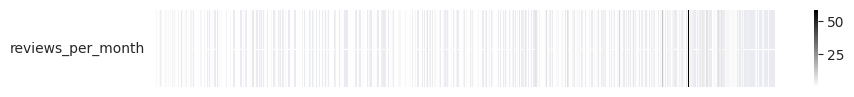

['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']


['neighbourhood_group', 'neighbourhood', 'room_type']


CPU times: user 1.05 s, sys: 155 ms, total: 1.21 s
Wall time: 1.01 s


In [4]:
%%time

strFileName='AB_NYC_2019.csv'

# # Предварительная оценка данных шла на выборке
# topNrows = 5000
# df = pd.read_csv(strFileName, delimiter=',', nrows = topNrows)

df = pd.read_csv(strFileName, delimiter=',', engine='pyarrow') # пока нет совместимости pyarrow и архивации (или не нашел)
                                                               # по этой причине без compression='gzip'

df=df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'])

cols_num, cols_str= short_describe(df)

<hr>

### Test correlation on sample

In [5]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df=df[cols_num], crit=0.85, method='spearman'):    
    au_corr = df.corr(method=method).abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[au_corr>crit]


In [6]:
crit=0.8
corr_df=df[cols_num].sample(n=1000,random_state=202402)
result=get_top_abs_correlations(df=corr_df, crit=crit, method='pearson')
display(HTML(f'<b>Strong correlation (>{crit}): {result.shape[0]} pairs</b><hr>'))
print(result)

Series([], dtype: float64)


<b><span style="color:red">depricated:</span></b> <span style="color:lightgray">
The most likely candidate for drop is field <b>number_of_reviews</b>,<br>
which is obviously closely related to field <b>reviews_per_month</b></span>

<span style="color:lightgray">
#CODE

drop_candidate='number_of_reviews'

df=df.drop(columns=drop_candidate)

cols_num.remove(drop_candidate)
</span>

<hr>

### Correlation matrix (triangular)

In [7]:
corr_df= df[cols_num].corr(method='pearson').abs()
df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(bool))
df_lt.style.background_gradient().highlight_null(color="white").format('{:.3f}')

### Categorical feaches

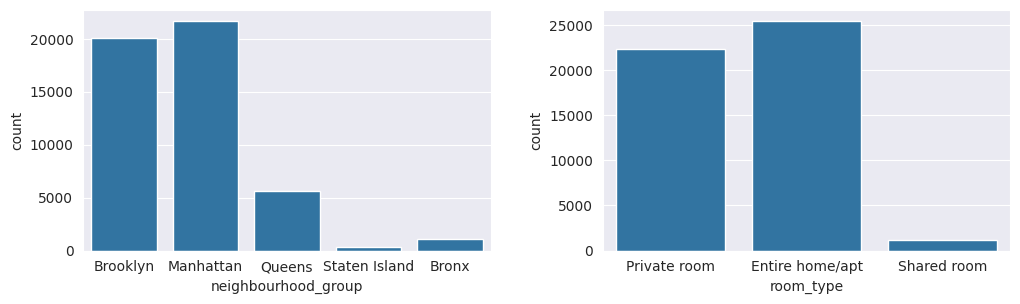

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
fig.tight_layout(h_pad=5,w_pad=5)
sns.countplot(ax=ax[0],x='neighbourhood_group',data=df)
sns.countplot(ax=ax[1],x='room_type',data=df)
plt.show()

In [9]:
pivot_df=pd.pivot_table(df, values='price',
                        index=['neighbourhood_group'],columns=['room_type'],
                        aggfunc={"mean","count","std"})
display(pivot_df.style.background_gradient().format('{:.0f}'))

<hr>

### Сontinuous feaches

#### Price

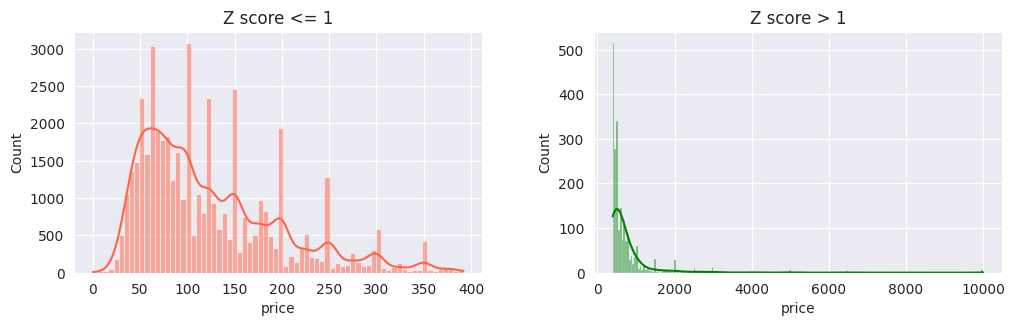

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
fig.tight_layout(h_pad=5,w_pad=5)

crit=1
sns.histplot(ax=ax[0],
             data=df.where(zscore(df['price']) <= crit),
             kde=True,x='price', color='tomato')
ax[0].set_title(f'Z score <= {crit}')

sns.histplot(ax=ax[1],
             data=df.where(zscore(df['price']) > crit),
             kde=True,x='price', color='green')
ax[1].set_title(f'Z score > {crit}')

display(HTML(f'<img src="scr/Normal_distribution_and_scales.gif" width="500"/>'))

plt.show()

In [11]:
zero_price_rows=df[df["price"]==0]
display(HTML(f'<b><span style="color:red">Hypothesis: </span>  DROP {zero_price_rows["price"].count()} rows </b> with zero price<hr>'))
display(zero_price_rows)

neighbourhood_group       neighbourhood  latitude  longitude  \
23161            Brooklyn  Bedford-Stuyvesant  40.69023  -73.95428   
25433               Bronx     East Morrisania  40.83296  -73.88668   
25634            Brooklyn            Bushwick  40.69467  -73.92433   
25753            Brooklyn          Greenpoint  40.72462  -73.94072   
25778            Brooklyn        Williamsburg  40.70838  -73.94645   
25794            Brooklyn  Bedford-Stuyvesant  40.68173  -73.91342   
25795            Brooklyn  Bedford-Stuyvesant  40.68279  -73.91170   
25796            Brooklyn  Bedford-Stuyvesant  40.68258  -73.91284   
26259           Manhattan         Murray Hill  40.75091  -73.97597   
26841            Brooklyn            Bushwick  40.69211  -73.90670   
26866            Brooklyn            Bushwick  40.69166  -73.90928   

             room_type  price  minimum_nights  number_of_reviews  \
23161     Private room      0               4                  1   
25433     Private room      0               2                 55   
25634     Private room      0               2                 16   
25753     Private room      0               2                 12   
25778  Entire home/apt      0               5                  3   
25794     Private room      0               1                 93   
25795     Private room      0               1                 95   
25796     Private room      0               1                 95   
26259  Entire home/apt      0               3                  0   
26841      Shared room      0              30                  2   
26866      Shared room      0              30                  5   

       reviews_per_month  calculated_host_listings_count  availability_365  
23161               0.05                               4                28  
25433               2.56                               4               127  
25634               0.71                               5                 0  
25753               0.53                               2                 0  
25778               0.15                               1                73  
25794               4.28                               6               176  
25795               4.37                               6               232  
25796               4.35                               6               222  
26259                NaN                               1                 0  
26841               0.11                               6               333  
26866               0.26                               6               139

#### reviews_per_month

In [12]:
tempdata_df=df.loc[df['reviews_per_month'].isnull()]
display(tempdata_df['number_of_reviews'].describe().to_frame().T)

display(HTML(f'<b><span style="color:red">Hypothesis: </span></b>  reviews_per_month = number_of_reviews / month_count<hr>'))


count  mean  std  min  25%  50%  75%  max
number_of_reviews  10052.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0

<hr>

### Pairplot

CPU times: user 29.7 s, sys: 630 ms, total: 30.3 s
Wall time: 30 s


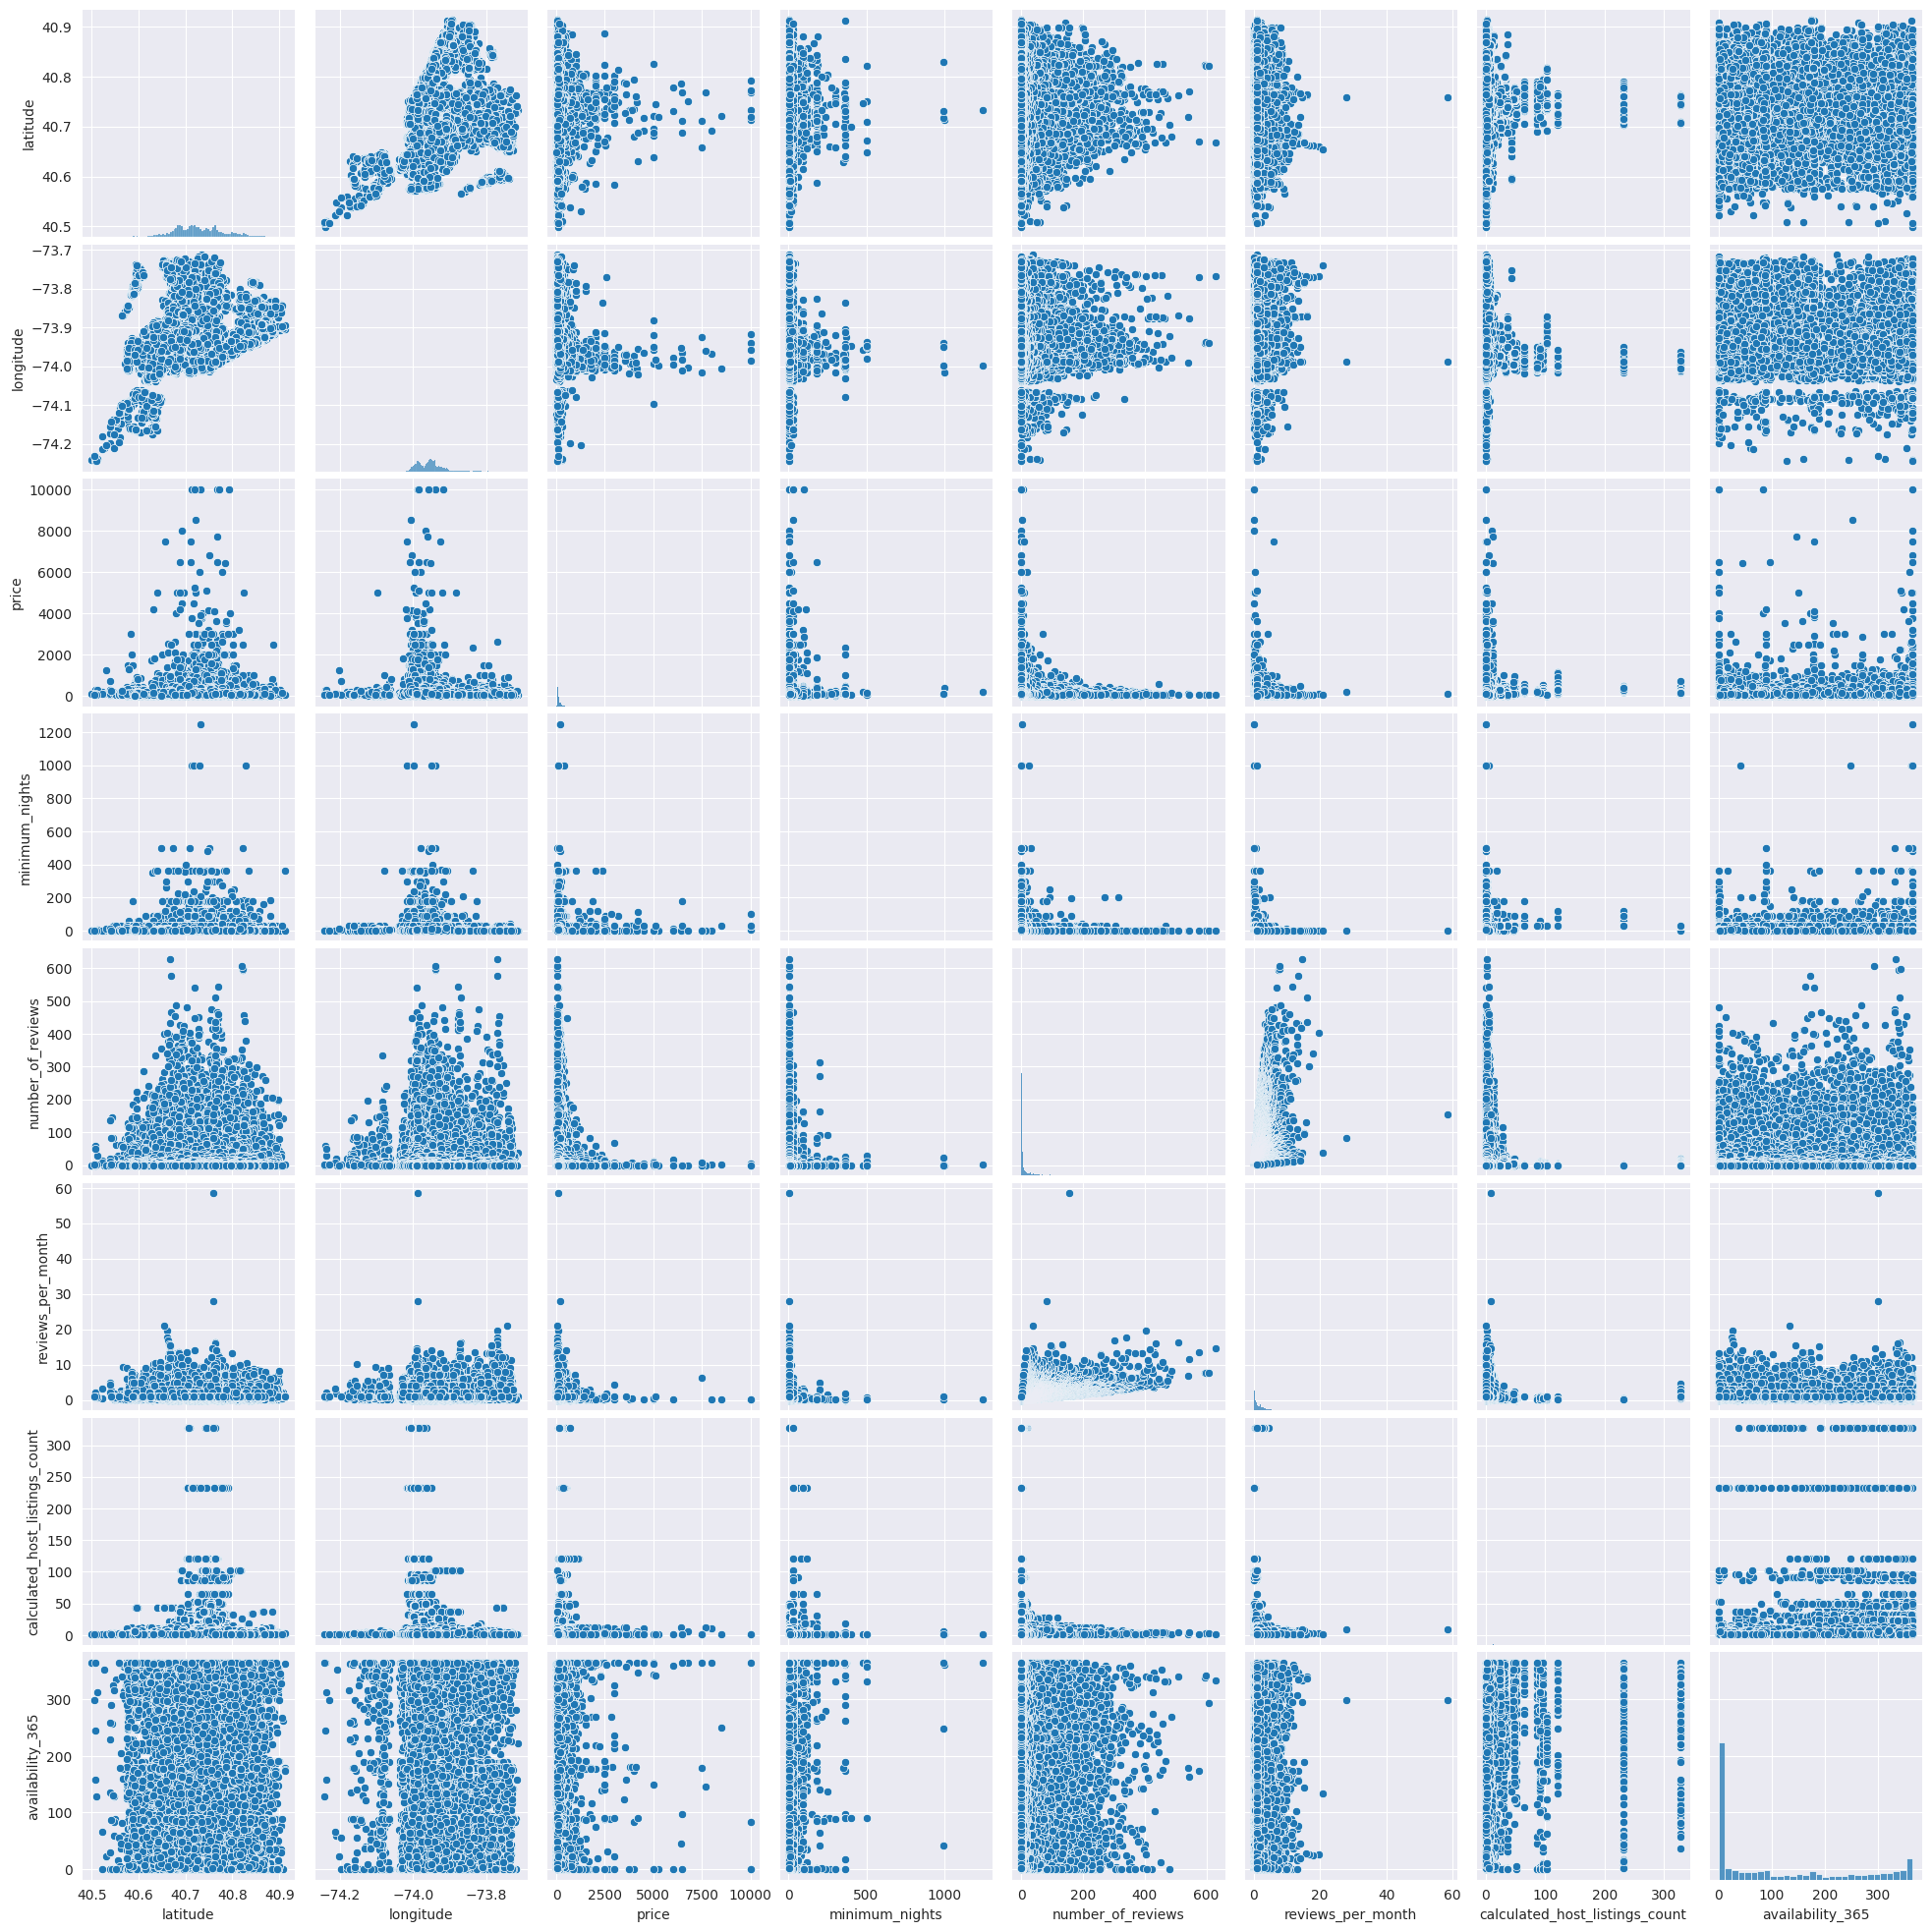

In [13]:
%%time
sns.pairplot(data=df)

<hr>

### Часть 2. Preprocessing & Feature Engineering

<br>Цель получить как можно более высокие метрики качества (взяты R2, MAE, RMSE), сконцентрировавшись на преобразовании признаков.
<br>Испытаны различные техники:
<ul><li>работа с категориальными переменными;</li>
<li>замена аномалий;</li>
<li>различные варианты шкалирования непрерывных переменных (StandardScaler, RobustScaler, и.т.д.);</li>
<li>проведена работа с целевой переменной;</li>
</ul>

#### Price

<b><span style="color:red">Action: </span></b> DROP 11 rows with zero price 

In [14]:
df = df.drop(df[df['price'] == 0].index)

Max price

<i>Additional research</i>

In [15]:
df_z_price=df[['neighbourhood_group','room_type','price']]

df_z_price['z_price']=zscore(df_z_price['price']).abs()
df_z_price['z_price_group']=round(df_z_price['z_price'],0)
df_z_price.loc[df_z_price["z_price_group"]>5, "z_price_group"] = 5

display(df_z_price.value_counts('z_price_group',normalize=True).to_frame().T)

pivot_df=pd.pivot_table(df_z_price, values='price',
                        columns=['z_price_group'], index=['room_type'],
                        aggfunc={"mean","count","min"})
display(pivot_df)

z_price_group       0.0       1.0       2.0       5.0       3.0       4.0
proportion     0.885484  0.093343  0.010781  0.003928  0.003825  0.002639

count                                  mean              \
z_price_group      0.0   1.0  2.0  3.0  4.0  5.0         0.0         1.0   
room_type                                                                  
Entire home/apt  21047  3476  473  156  107  148  151.774552  349.934983   
Private room     21394   782   53   28   20   42   78.818033  163.997442   
Shared room        845   305    1    3    2    2   68.353846   50.537705   

                                                                  min      \
z_price_group           2.0         3.0          4.0          5.0 0.0 1.0   
room_type                                                                   
Entire home/apt  634.947146  847.923077  1053.859813  2873.905405  33  10   
Private room     633.641509  872.142857  1019.350000  2656.690476  33  10   
Shared room      725.000000  800.000000  1000.000000  1525.000000  33  10   

                                       
z_price_group    2.0  3.0   4.0   5.0  
room_type                              
Entire home/apt  515  760   995  1250  
Private room     515  794   995  1250  
Shared room      725  800  1000  1250

<hr><b><span style="color:red">Action: </span></b>Set price upper bound to N-sigma

In [16]:
sigma=3
price_upper_bound=df_z_price[df_z_price['z_price_group']>=sigma]['price'].min()

df['target_price']=df['price']
df.loc[df["target_price"]>price_upper_bound, "target_price"] = price_upper_bound

display(df["target_price"].describe().to_frame().T)

count        mean         std   min   25%    50%    75%    max
target_price  48884.0  143.587738  119.821522  10.0  69.0  106.0  175.0  760.0

#### New columns

<b><span style="color:red">depricated:</span></b> <span style="color:lightgray">'latitude', 'longitude' -> to one field. </span>

<b><span style="color:red">Action: </span></b>
<br>reviews_per_month -> reviews_months
<br>transfer into order variable

In [17]:
col_target='reviews_months'
df[col_target]=df['number_of_reviews']/df['reviews_per_month']
df[col_target].fillna(0, inplace=True)
df[col_target] = df[col_target].astype('int')
df[col_target].describe().to_frame().T

count       mean        std  min  25%   50%   75%    max
reviews_months  48884.0  21.603592  22.740008  0.0  1.0  14.0  35.0  128.0

<b><span style="color:red">depricated:</span></b> <span style="color:lightgray">
<br><b>Action:</b>
<br>minimum_nights -> minimum_nights_group
<br>calculated_host_listings_count_group -> calculated_host_listings_count
<br>transfer them into categorical variables</span>

In [18]:
'''
columns_list=(('minimum_nights_group',
               'minimum_nights', 5),
              ('calculated_host_listings_count_group',
               'calculated_host_listings_count', 6)
             )

for i in columns_list:
    df[i[0]]=df[i[1]]
    df.loc[df[i[1]]>i[2], i[0]] = i[2]+1
    df[i[0]]=df[i[0]].astype("str")

pivot_df=pd.pivot_table(df, values='price',
                        index=['calculated_host_listings_count_group'],columns=['minimum_nights_group'],
                        aggfunc={'count', 'mean'})
display(pivot_df.style.background_gradient().format('{:.0f}'))
'''


'\ncolumns_list=((\'minimum_nights_group\',\n               \'minimum_nights\', 5),\n              (\'calculated_host_listings_count_group\',\n               \'calculated_host_listings_count\', 6)\n             )\n\nfor i in columns_list:\n    df[i[0]]=df[i[1]]\n    df.loc[df[i[1]]>i[2], i[0]] = i[2]+1\n    df[i[0]]=df[i[0]].astype("str")\n\npivot_df=pd.pivot_table(df, values=\'price\',\n                        index=[\'calculated_host_listings_count_group\'],columns=[\'minimum_nights_group\'],\n                        aggfunc={\'count\', \'mean\'})\ndisplay(pivot_df.style.background_gradient().format(\'{:.0f}\'))\n'

<hr>

### Map
<i>just an illustration</i>

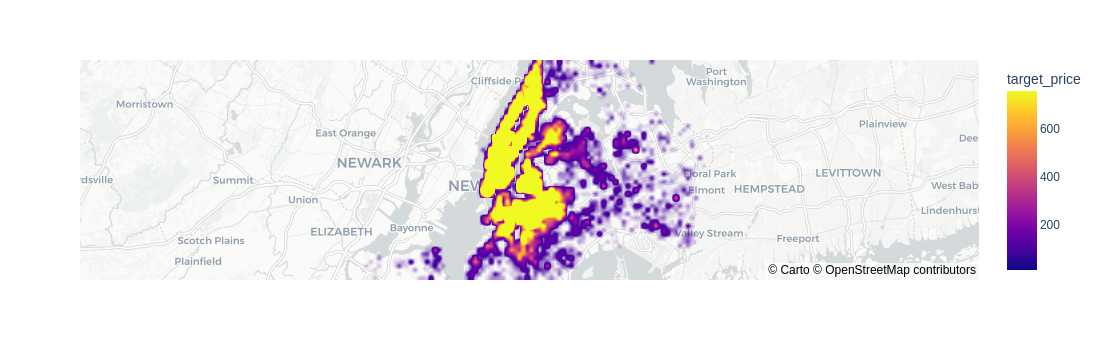

In [19]:
center_point = dict(
    lat = np.mean(df['latitude']),
    lon = np.mean(df['longitude'])
)

fig = px.density_mapbox(
    df, z='target_price', lat='latitude', lon='longitude',
    center=center_point, radius=3, zoom=9, mapbox_style='carto-positron')

fig.show()

<hr>

### Часть 3. Моделирование

<br>Отложено 30% данных для тестирования.
<br>Построена модель простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV.
<br>Измерено качество каждого варианта, результаты представлены в виде упорядоченного фрейма для последующего использования.

<b><span style="color:blue">RANDOM_STATE</span></b>

In [20]:
RANDOM_STATE=202402

<b><span style="color:red">Action: </span></b> define <b>dataframe</b>, <b>feaches</b>, <b>target</b> for modeling

In [21]:
col_scaler=[
    'latitude', 'longitude',
    'number_of_reviews', 'reviews_months',
    'availability_365',
    'minimum_nights', 'calculated_host_listings_count',
]

col_encoder=[
    'neighbourhood_group', 'neighbourhood', 'room_type',
#     'minimum_nights_group', 'calculated_host_listings_count_group', # depricated variant
]

col_target=['target_price']

df_model = df[col_target + col_scaler + col_encoder]

cols_num, cols_str = short_describe(df_model, sample_size=4)

['target_price', 'latitude', 'longitude', 'number_of_reviews', 'reviews_months', 'availability_365', 'minimum_nights', 'calculated_host_listings_count']


['neighbourhood_group', 'neighbourhood', 'room_type']


<b><span style="color:blue">Basic definitions</span></b>

In [22]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from category_encoders import CountEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

In [23]:
encoders = [
    #OneHotEncoder(), # depricated variant
    OrdinalEncoder(),
    LabelEncoder(),
    CountEncoder(),
]

scalers = [
    MinMaxScaler(),
    StandardScaler(),
    RobustScaler(),
]

cvg=5 #cross-validation generator
models = [
    LinearRegression(),
    RidgeCV(cv=cvg),
    LassoCV(cv=cvg, random_state=RANDOM_STATE),
    ElasticNetCV(cv=cvg, random_state=RANDOM_STATE)
]


<b><span style="color:blue">train / test split</span></b>

In [24]:
test_size=.3
train_size=1-test_size

X = df_model.drop(col_target, axis=1)
y = df_model[col_target].astype(float)

X_train, X_test, y_train, y_test = \
    train_test_split(X, y,
                     train_size=train_size,
                     shuffle=True,
                     random_state=RANDOM_STATE)

print('X_train:',X_train.shape, 'y_train:',y_train.shape)
print('X_test:' ,X_test.shape,  'y_test:' ,y_test.shape)

X_train: (34218, 10) y_train: (34218, 1)
X_test: (14666, 10) y_test: (14666, 1)


<b><span style="color:blue">test bench</span></b>

In [25]:
results=pd.DataFrame(columns=['model', 'encoder', 'scaler', 'MAE', 'MSE', 'R2', 'timestamp'])

In [26]:
def add_result(X_train, X_test, y_train, y_test,
               model,encoder,scaler,
               cat_columns=col_encoder, con_columns=col_scaler,
               results=results):
    
    encoded_X_train=X_train.copy()
    encoded_X_test =X_test.copy()
    
    for c in cat_columns:
        encoded_X_train[c] = encoder.fit_transform(encoded_X_train[[c]])
        encoded_X_test [c] = encoder.fit_transform( encoded_X_test[[c]])
    
    for c in con_columns:        
        encoded_X_train[c] = scaler.fit_transform(encoded_X_train[[c]])
        encoded_X_test [c] = scaler.fit_transform( encoded_X_test[[c]])
        
        
    model.fit(encoded_X_train, y_train)
    y_pred = model.predict(encoded_X_test)
    
    d={
        'model'     : [type(model).__name__],
        'encoder'   : [type(encoder).__name__],
        'scaler'    : [type(scaler).__name__],
        'MAE'       : [mean_absolute_error(y_test, y_pred)],
        'MSE'       : [mean_squared_error(y_test, y_pred)],
        'R2'        : [r2_score(y_test, y_pred)],
        'timestamp' : [datetime.now()],
    }

    results=pd.concat([results, pd.DataFrame(data=d)],ignore_index=True)
    
    return results

<b><span style="color:red">Action: </span></b> go !

In [27]:
%%time

results=pd.DataFrame(columns=['model', 'encoder', 'scaler', 'MAE', 'MSE', 'R2', 'timestamp'])

for model in models:
    for encoder in encoders:
        for scaler in scalers:
            results = add_result(X_train, X_test, y_train, y_test,
                                 model,encoder,scaler,
                                 cat_columns=col_encoder, con_columns=col_scaler,
                                 results=results)

results=results.sort_values(by=['MAE','MSE','R2'])

display(results[['model','encoder','scaler', 'MAE','MSE','R2']].style.background_gradient().\
        format({"MAE" : "{:,.1f}","MSE" : "{:,.0f}","R2"  : "{:.3f}",})
       )


CPU times: user 44.8 s, sys: 27.1 s, total: 1min 11s
Wall time: 32 s
